In [79]:
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### import data

#### 95th percentile  treshold  Recent K commits 

In [80]:
import os
import pandas as pd

def process_commit_history(csv_file, current_time="2023-11-1", k=30):
    df = pd.read_csv(csv_file)
    df = df.dropna(subset=['date'])
    if df.empty:
        return None
    
    df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    
    # Filter only dates up to and including November 1, 2023
    cut_off_date = '2023-11-1'
    df = df[df['date'] <= pd.to_datetime(cut_off_date)]
    
    # Check again if DataFrame is empty after filtering by date
    if df.empty:
        return None
    
    df['timestamp'] = df['date'].astype('datetime64[s]')
    df = df.sort_values(by=['timestamp'], ascending=True)
    
        # most recent k commits
    if len(df) > k:
        df = df.iloc[-k:]
    
    df['interval'] = df['timestamp'].diff().dt.total_seconds()
    
    # Ensure there's at least one row before proceeding
    if not df.empty:
        df['interval'] = df['timestamp'].diff().dt.total_seconds()
        
        # Calculate the mean and standard deviation of commit intervals
        mean_interval = df['interval'].mean()
        sd_interval = df['interval'].std()
        
        Z = df['interval'].max()
        percentile_95 = df['interval'].dropna().quantile(0.95)
        T = pd.to_datetime(current_time)
        T_X_n = (T - df['timestamp'].iloc[-1]).total_seconds()
        time_since_last_commit_days = T_X_n / (60 * 60 * 24)
            
        classification = "unknown"
        if T_X_n > Z:
            # Reclassify as "alive" if within a certain SD from the mean
            if abs(T_X_n - mean_interval) < sd_interval:
                classification = "alive"
            else:
                classification = "dead"
        elif T_X_n < percentile_95:
            classification = "alive"
            
        mean_interval = mean_interval / (60 * 60 * 24)
        
        repo_name = os.path.basename(csv_file).split('.')[0]
        return {
            'Repo': repo_name,
            'Z': Z,
            'T_X_n': T_X_n,
            'Percentile_95': percentile_95,
            'MeanInterval(days)': mean_interval,
            'SDInterval': sd_interval,
            'Label': classification,
            'TimeSinceLastCommit(days)': time_since_last_commit_days
        }
    else:
        return None
    
folder_path = '/Users/ethan/Documents/Datascience/MQP/main_repo_df/Data/CommitData' 

#folder_path = '../../Data/CommitData'   
results_list = []  

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        csv_path = os.path.join(folder_path, file_name)
        result = process_commit_history(csv_path)
        if result:  # Only add if result is not None
            results_list.append(result)

C:\Users\ethan\AppData\Local\Temp\ipykernel_12116\4264307182.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
C:\Users\ethan\AppData\Local\Temp\ipykernel_12116\4264307182.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)


    classification = "unknown"
    if T_X_n > Z:
        classification = "dead"
        # If classified as dead but within 1 SD from the mean, reclassify as alive
        if abs(T_X_n - mean_interval) < sd_interval:
            classification = "alive"
    elif T_X_n < percentile_95:
        classification = "alive"
   

In [81]:
results_df = pd.DataFrame(results_list)

In [82]:
def split_repo_identifier(repo_identifier):
    if repo_identifier.startswith('C_'):
        repo_identifier = repo_identifier[2:]  # remove the 'C_' prefix
    parts = repo_identifier.split('_', 1)
    owner = parts[0]
    repo = parts[1] if len(parts) > 1 else ''
    return owner, repo
results_df[['Owner', 'Repo']] = results_df['Repo'].apply(lambda x: split_repo_identifier(x)).tolist()


results_df =results_df [['Repo', 'Owner','Z', 'T_X_n', 'Percentile_95', 'MeanInterval(days)',
       'SDInterval', 'Label', 'TimeSinceLastCommit(days)' ]]


In [83]:
results_df.to_csv('../data/df_95thp_labeled.csv', index=False)

In [84]:
results_df.head(1)

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days)
0,campus_recruitmen_questions,0voice,1468386.0,68899153.0,989884.8,1.588616,360444.837056,dead,797.4439


In [85]:
results_df['TimeSinceLastCommit(days)'].describe()

count    1750.000000
mean      697.010614
std       916.319340
min         0.000359
25%        20.133247
50%       243.054242
75%      1125.422934
max      4959.900463
Name: TimeSinceLastCommit(days), dtype: float64

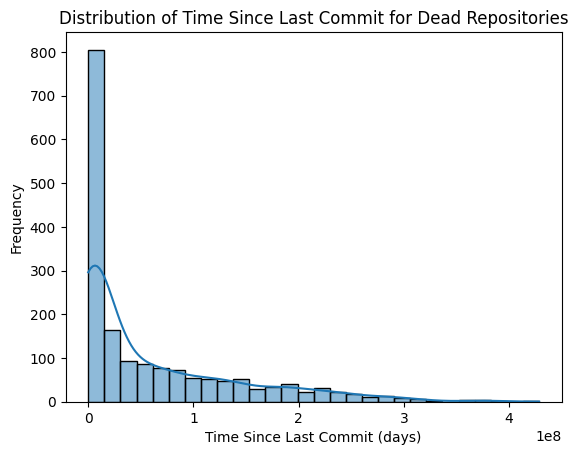

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(results_df['T_X_n'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()


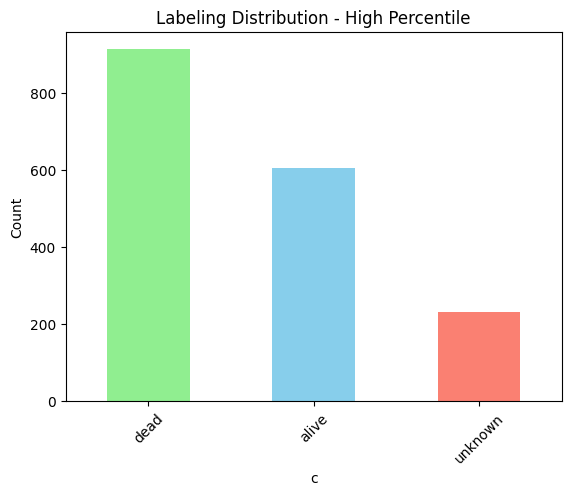

In [230]:
import matplotlib.pyplot as plt

classification_counts = results_df['Label'].value_counts()
classification_counts.plot(kind='bar', color=['lightgreen','skyblue',  'salmon'])
plt.title('Labeling Distribution - High Percentile')
plt.xlabel('c')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

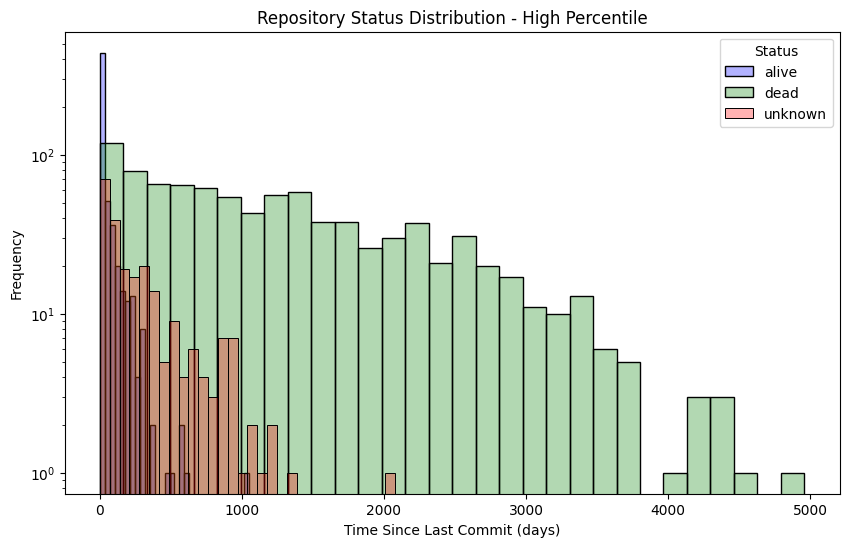

In [228]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

colors = {'alive':'blue' , 'dead': 'green', 'unknown': 'red'}

plt.figure(figsize=(10, 6))

for classification, color in colors.items():
    sns.histplot(data=results_df[results_df['Label'] == classification],
                 x='TimeSinceLastCommit(days)',
                 bins=30,
                 alpha=0.3,
                 label=classification,
                 color=color,
                 edgecolor='black')

plt.yscale('log')
plt.title('Repository Status Distribution - High Percentile')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.legend(title='Status')


plt.show()


#### Dead repos 

In [89]:
dead_repos_df = results_df[results_df['Label'] == 'dead']
dead_repos_df.head(10)

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days)
0,campus_recruitmen_questions,0voice,1468386.0,68899153.0,989884.80,1.588616,3.604448e+05,dead,797.443900
2,CompressorQueue,1Danish-00,31220268.0,32941934.0,19001707.50,41.994261,9.370872e+06,dead,381.272384
3,developer_quest,2d-inc,6848421.0,122169888.0,6099397.60,7.840104,1.944424e+06,dead,1414.003333
5,QingScan,78778443,7278693.0,12067368.0,6344818.20,9.588466,2.045000e+06,dead,139.668611
7,iOS-Developer-and-Designer-Interview-Questions,9magnets,52066745.0,202473979.0,11257996.40,30.371325,9.972051e+06,dead,2343.448831
9,Leetcode-Questions,AbhishekChourasiya,356.0,123501401.0,356.00,0.004120,NaN,dead,1429.414363
10,Quiz-App-Flutter,abuanwar072,28052746.0,51827304.0,22938332.75,68.840289,1.124620e+07,dead,599.853056
11,node-restful-api-tutorial,academind,126883.0,186837657.0,120851.95,0.770515,8.529193e+04,dead,2162.472882
12,road-runner-quickstart,acmerobotics,495882.0,873624.0,446981.20,1.811179,1.508084e+05,dead,10.111389
14,stacks-queues,AdaGold,28410344.0,49016485.0,15707249.00,32.585365,6.825955e+06,dead,567.320428


In [90]:
sorted_dead_repos_df = dead_repos_df.sort_values(by='TimeSinceLastCommit(days)')
sorted_dead_repos_df

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days)
1617,first-quiz,VelezReyes,46500.0,89062.0,40379.2,0.140616,1.697491e+04,dead,1.030810
281,Queen-AI,DarkWinzo,69544.0,209926.0,37855.6,0.063135,1.595822e+04,dead,2.429699
1349,oh-my-zsh,robbyrussell,234860.0,288675.0,220352.4,0.560391,6.884211e+04,dead,3.341146
590,java-design-patterns,iluwatar,257531.0,314299.0,113664.4,0.193370,5.447513e+04,dead,3.637720
1295,qucs_s,ra3xdh,91377.0,320399.0,85529.4,0.275808,3.036491e+04,dead,3.708322
...,...,...,...,...,...,...,...,...,...
1137,phpQuery,punkave,364.0,376822234.0,364.0,0.004213,NaN,dead,4361.368449
875,NewQuickAction3D,lorensiuswlt,7033736.0,380068774.0,5798779.8,18.357984,3.067312e+06,dead,4398.944144
570,quora,huacnlee,1575684.0,380569967.0,800899.2,1.889645,3.499387e+05,dead,4404.744988
1112,jQuery-MD5,placemarker,7546712.0,390821102.0,5972567.2,19.857190,2.504764e+06,dead,4523.392384


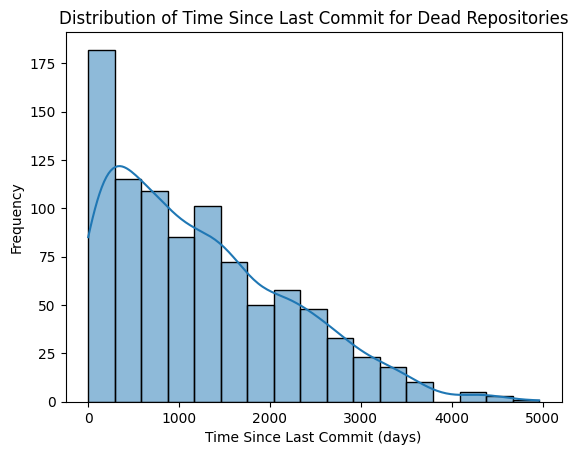

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(dead_repos_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()


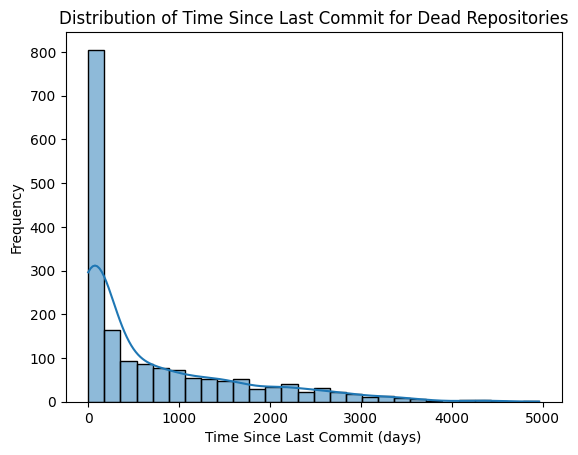

In [92]:
 
sns.histplot(results_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

#### Alive repos 

In [93]:
alive_repos_df = results_df[results_df['Label'] == 'alive']
alive_repos_df.head(10)


,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days)
1,linux-insides,0xAX,9252379.0,5226272.0,7554093.6,13.694319,2.589807e+06,alive,60.489259
4,Kuai-Shua-Questions,350306878,64032394.0,4638526.0,39589406.6,59.179903,1.511107e+07,alive,53.686644
8,jQuery,aamirafridi,64920542.0,25886232.0,38042486.6,64.752743,1.575285e+07,alive,299.609167
27,lottie-android,airbnb,4840517.0,157247.0,2112091.0,5.897907,1.027028e+06,alive,1.819988
29,qemu_blog,airbus-seclab,24165616.0,13280964.0,21690479.7,51.195907,8.593245e+06,alive,153.714861
30,vux,airyland,25317099.0,11114467.0,13818460.2,25.340280,5.623290e+06,alive,128.639664
33,awesome-java,akullpp,8377543.0,303519.0,6622214.0,9.345566,2.219838e+06,alive,3.512951
34,Alamofire,Alamofire,2999427.0,447125.0,2151970.6,5.904027,8.099443e+05,alive,5.175058
35,QSimpleUpdater,alex-spataru,22821404.0,1578615.0,19527508.8,56.117694,6.551253e+06,alive,18.271007
36,skill-sample-nodejs-quiz-game,alexa-samples,82848861.0,17023593.0,19585149.2,57.623844,1.586120e+07,alive,197.032326


In [94]:
sorted_alive_repos_df = alive_repos_df.sort_values(by='TimeSinceLastCommit(days)', ascending=False)
sorted_alive_repos_df

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days)
196,QrCodeScan,chentao0707,193643383.0,90865192.0,1.096517e+08,241.074126,6.076016e+07,alive,1051.680463
1592,ud843-QuakeReport,udacity,182957271.0,53868559.0,1.829573e+08,2117.561007,NaN,alive,623.478692
1510,lab-mysql-first-queries,ta-data-lis,82269216.0,50314358.0,6.170421e+07,158.716489,3.358550e+07,alive,582.342106
1578,How-To-Ask-Questions-The-Smart-Way,tvvocold,154258970.0,49141981.0,1.367203e+08,516.587500,6.758521e+07,alive,568.772928
1563,qsreplace,tomnomnom,82187479.0,42781581.0,7.026392e+07,245.615961,4.066405e+07,alive,495.157188
...,...,...,...,...,...,...,...,...,...
1251,QuestPDF,QuestPDF,894255.0,2095.0,5.638520e+05,1.559086,2.191632e+05,alive,0.024248
1310,react-querybuilder,react-querybuilder,233019.0,2023.0,9.099880e+04,0.237116,4.806723e+04,alive,0.023414
189,certbot,certbot,398218.0,1904.0,2.654134e+05,0.737688,9.901881e+04,alive,0.022037
1258,quickemu,quickemu-project,261557.0,807.0,2.090244e+05,0.654747,7.293609e+04,alive,0.009340


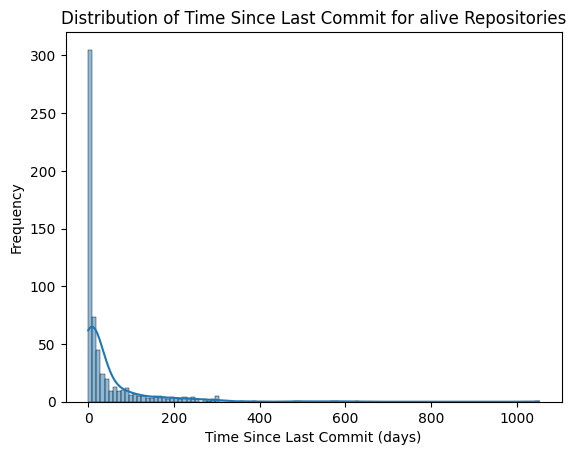

In [95]:

sns.histplot(alive_repos_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for alive Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

In [96]:
dead_repos_df

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days)
0,campus_recruitmen_questions,0voice,1468386.0,68899153.0,989884.8,1.588616,3.604448e+05,dead,797.443900
2,CompressorQueue,1Danish-00,31220268.0,32941934.0,19001707.5,41.994261,9.370872e+06,dead,381.272384
3,developer_quest,2d-inc,6848421.0,122169888.0,6099397.6,7.840104,1.944424e+06,dead,1414.003333
5,QingScan,78778443,7278693.0,12067368.0,6344818.2,9.588466,2.045000e+06,dead,139.668611
7,iOS-Developer-and-Designer-Interview-Questions,9magnets,52066745.0,202473979.0,11257996.4,30.371325,9.972051e+06,dead,2343.448831
...,...,...,...,...,...,...,...,...,...
1738,QtQuickExamples,zhengtianzuo,68831082.0,86118093.0,14919649.0,40.831971,1.316481e+07,dead,996.737188
1739,QASystemOnMedicalGraph,zhihao-chen,5260996.0,140123163.0,3551732.6,8.984473,1.491984e+06,dead,1621.795868
1741,AiQiangGUO,zhuxuedefeng,8192130.0,77047176.0,4929800.4,12.130486,2.297861e+06,dead,891.749722
1742,awesome-php,ziadoz,6268706.0,40185453.0,5225338.0,11.658948,1.865049e+06,dead,465.109410


#### Unknown

In [97]:
unknown = results_df[results_df['Label'] == 'unknown']

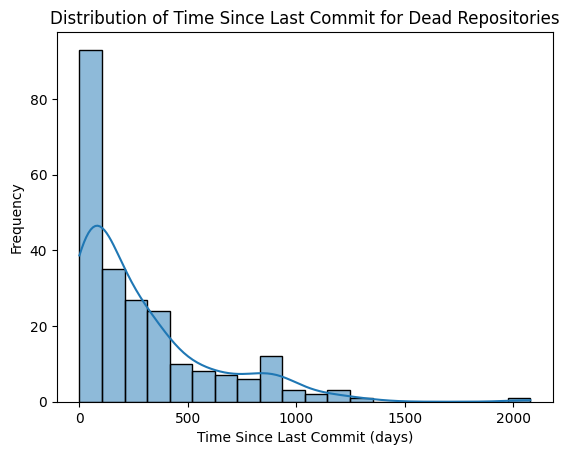

In [98]:
 
sns.histplot(unknown['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

#### Repo Validation Status  

  github api to verify; if 'verify' or 'Error' manualy look up and check status 

In [99]:
import pandas as pd
import requests
from datetime import datetime, timedelta

df = results_df  

 
def check_repo_status_and_date(owner, repo_name, token, alive_threshold=30, verify_threshold=90):
    headers = {
        'Authorization': f'token {token}',
        'Accept': 'application/vnd.github.v3+json'
    }
    url = f'https://api.github.com/repos/{owner}/{repo_name}/commits'
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        commits = response.json()
        if commits:
            latest_commit_date_str = commits[0]['commit']['committer']['date']
            latest_commit_date = datetime.strptime(latest_commit_date_str, '%Y-%m-%dT%H:%M:%SZ')
            days_since_last_commit = (datetime.utcnow() - latest_commit_date).days
            status = 'True' if days_since_last_commit < alive_threshold else ('verify' if days_since_last_commit <= verify_threshold else 'False')
            return status, latest_commit_date_str
        else:
            return 'False', None  # No commits found
    else:
        print(f"Error fetching repo {repo_name}: {response.status_code}")
        return 'Error', None  # Error state

 
token = 'xxxxxxxxxxxxxxxxxxxxxxxxxx'

 
df['Status'] = 'Error'
df['Last_Commit_Date'] = None

 
for index, row in df.iterrows():
    status, last_commit_date = check_repo_status_and_date(row['Owner'], row['Repo'], token)
    df.at[index, 'Status'] = status
    df.at[index, 'Last_Commit_Date'] = last_commit_date

 
df.head()


Error fetching repo fullPage: 404
Error fetching repo Chart: 404
Error fetching repo validator: 404
Error fetching repo qikqiak: 404
Error fetching repo Quartz: 404
Error fetching repo jQuery: 404
Error fetching repo Parsley: 404
Error fetching repo reveal: 404
Error fetching repo hammer: 404
Error fetching repo jQuery: 404
Error fetching repo jQuery: 404
Error fetching repo fabric: 404
Error fetching repo qart: 404
Error fetching repo queues: 404
Error fetching repo backbone: 404
Error fetching repo graph: 404
Error fetching repo jQuery: 404
Error fetching repo mithril: 404
Error fetching repo Newbe: 404
Error fetching repo nw: 404
Error fetching repo qqwry: 404
Error fetching repo paper: 404
Error fetching repo pixi: 404
Error fetching repo qbzzt: 404
Error fetching repo qiubaiying: 404
Error fetching repo qpython3: 404
Error fetching repo QuantEcon: 404
Error fetching repo QuantEcon: 404
Error fetching repo quarkusio: 404
Error fetching repo org: 404
Error fetching repo quran: 404
E

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days),Status,Last_Commit_Date
0,campus_recruitmen_questions,0voice,1468386.0,68899153.0,989884.8,1.588616,3.604448e+05,dead,797.443900,False,2021-08-25T13:20:47Z
1,linux-insides,0xAX,9252379.0,5226272.0,7554093.6,13.694319,2.589807e+06,alive,60.489259,False,2023-09-01T12:15:28Z
2,CompressorQueue,1Danish-00,31220268.0,32941934.0,19001707.5,41.994261,9.370872e+06,dead,381.272384,verify,2024-01-03T12:12:34Z
3,developer_quest,2d-inc,6848421.0,122169888.0,6099397.6,7.840104,1.944424e+06,dead,1414.003333,False,2019-12-17T23:55:12Z
4,Kuai-Shua-Questions,350306878,64032394.0,4638526.0,39589406.6,59.179903,1.511107e+07,alive,53.686644,False,2023-09-08T07:31:14Z


In [100]:
#df.to_csv('../data/df_status_check.csv', index=False)

In [101]:
#df =pd.read_csv('../data/df_status_check.csv', sep=",") 

#### Manual Validation 
Selecting a random row from dead adn alive and finding the github and verfyiing if it is alive or dead  

In [102]:
df

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days),Status,Last_Commit_Date
0,campus_recruitmen_questions,0voice,1468386.0,68899153.0,989884.8,1.588616,3.604448e+05,dead,797.443900,False,2021-08-25T13:20:47Z
1,linux-insides,0xAX,9252379.0,5226272.0,7554093.6,13.694319,2.589807e+06,alive,60.489259,False,2023-09-01T12:15:28Z
2,CompressorQueue,1Danish-00,31220268.0,32941934.0,19001707.5,41.994261,9.370872e+06,dead,381.272384,verify,2024-01-03T12:12:34Z
3,developer_quest,2d-inc,6848421.0,122169888.0,6099397.6,7.840104,1.944424e+06,dead,1414.003333,False,2019-12-17T23:55:12Z
4,Kuai-Shua-Questions,350306878,64032394.0,4638526.0,39589406.6,59.179903,1.511107e+07,alive,53.686644,False,2023-09-08T07:31:14Z
...,...,...,...,...,...,...,...,...,...,...,...
1745,qrcode,zpao,12801097.0,243718.0,9045310.2,16.940681,3.281061e+06,alive,2.820810,Error,None
1746,rule_for_quantumultX,zqzess,604803.0,167234.0,405604.4,1.448310,1.580566e+05,alive,1.935579,True,2024-03-11T01:30:21Z
1747,quick_psd2ugui,zs9024,58344447.0,52406855.0,12187195.2,44.459197,1.118889e+07,unknown,606.560822,False,2022-03-04T10:32:25Z
1748,zxing,zxing,3024047.0,118115.0,883033.6,3.191948,5.967665e+05,alive,1.367072,True,2024-03-11T12:30:06Z


In [171]:
alive_repos_df = df[df['Label'] == 'alive']
random_row_alive = alive_repos_df.sample(n=1)
random_row_alive

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days),Status,Last_Commit_Date
1434,awesome,sindresorhus,5165424.0,464404.0,2613679.2,6.408617,1.124963e+06,alive,5.375046,verify,2024-02-14T08:09:43Z


In [225]:
dead_repos_df = df[df['Label'] == 'dead']
random_row_dead = dead_repos_df.sample(n=1)
random_row_dead

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days),Status,Last_Commit_Date
1653,webtorrent,webtorrent,789276.0,839295.0,538282.2,2.459984,229442.814705,dead,9.714063,True,2024-03-12T19:26:21Z


In [105]:
alive_repos_df.to_csv('../data/alive_repos_df.csv', index=False)

In [106]:
dead_repos_df.to_csv('../data/dead_repos_df.csv', index=False)

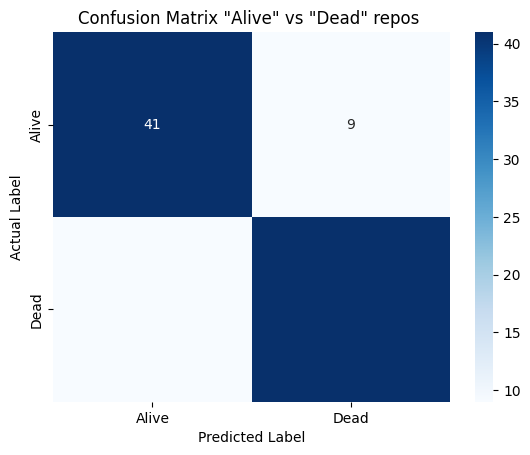

In [226]:
import matplotlib.pyplot as plt
import seaborn as sns



TP =  41 # True Positives
TN =  41 # True Negatives
FP =  9 # False Positives
FN =  9 # False Negatives

high percentile threshold


confusion_mtx = [[TP, FP],
                 [FN, TN]]

sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=['Alive', 'Dead'], yticklabels=['Alive', 'Dead'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix "Alive" vs "Dead" repos - high percentile threshold )
plt.show()




In [109]:
results_df

,Repo,Owner,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Label,TimeSinceLastCommit(days),Status,Last_Commit_Date
0,campus_recruitmen_questions,0voice,1468386.0,68899153.0,989884.8,1.588616,3.604448e+05,dead,797.443900,False,2021-08-25T13:20:47Z
1,linux-insides,0xAX,9252379.0,5226272.0,7554093.6,13.694319,2.589807e+06,alive,60.489259,False,2023-09-01T12:15:28Z
2,CompressorQueue,1Danish-00,31220268.0,32941934.0,19001707.5,41.994261,9.370872e+06,dead,381.272384,verify,2024-01-03T12:12:34Z
3,developer_quest,2d-inc,6848421.0,122169888.0,6099397.6,7.840104,1.944424e+06,dead,1414.003333,False,2019-12-17T23:55:12Z
4,Kuai-Shua-Questions,350306878,64032394.0,4638526.0,39589406.6,59.179903,1.511107e+07,alive,53.686644,False,2023-09-08T07:31:14Z
...,...,...,...,...,...,...,...,...,...,...,...
1745,qrcode,zpao,12801097.0,243718.0,9045310.2,16.940681,3.281061e+06,alive,2.820810,Error,None
1746,rule_for_quantumultX,zqzess,604803.0,167234.0,405604.4,1.448310,1.580566e+05,alive,1.935579,True,2024-03-11T01:30:21Z
1747,quick_psd2ugui,zs9024,58344447.0,52406855.0,12187195.2,44.459197,1.118889e+07,unknown,606.560822,False,2022-03-04T10:32:25Z
1748,zxing,zxing,3024047.0,118115.0,883033.6,3.191948,5.967665e+05,alive,1.367072,True,2024-03-11T12:30:06Z
